# 파이프라인 개요

## 대략적인 Pipeline 구현

In [1]:
from ml1.preamble import*
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
class My_Pipeline:
    
    def __init__(self, steps):
        self.steps = steps
        
    def fit(self, X, y):
        for name, estimator in self.steps[:-1]:
            X = estimator.fit_transform(X, y)
        self.steps[-1][1].fit(X, y)
        return self
    
    def score(self, X, y):
        for name, estimator in self.steps[:-1]:
            X = estimator.transform(X)
        return self.steps[-1][1].score(X, y)

In [3]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

my_pipe = My_Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])
my_pipe.fit(X_train, y_train)
print(f'테스트 점수: {my_pipe.score(X_test, y_test):.2f}')

테스트 점수: 0.97


## Scaler에서의 예

* Pipeline 미활용

In [4]:


scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC()
svm.fit(X_train_scaled, y_train)

print(f'테스트 점수: {svm.score(X_test_scaled, y_test):.2f}')

테스트 점수: 0.97


* Pipeline 활용

In [5]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])
pipe.fit(X_train, y_train)
print(f'테스트 점수: {pipe.score(X_test, y_test):.2f}')

테스트 점수: 0.97


## GridSearchCV에서의 예

* 잘못된 예

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv =5)
grid.fit(X_train_scaled, y_train)
print(f'최상의 교차 검증 정확도: {grid.best_score_:.2f}')
print(f'테스트 점수: {grid.score(X_test_scaled, y_test):.2f}')
print(f'최적의 매개변수: {grid.best_params_}')

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수: {'C': 1, 'gamma': 1}


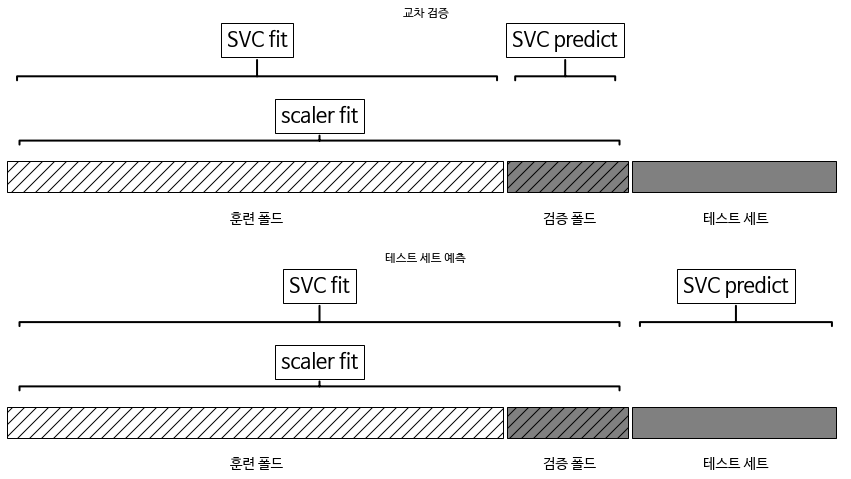

In [7]:
mglearn.plots.plot_improper_processing()

=> scaling을 할때 검증폴드까지 쓰므로 정보 누설이 됨

* Pipeline으로 수정

In [8]:
param_grid = {'svm__C':[0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print(f'최상의 교차 검증 정확도: {grid.best_score_:.2f}')
print(f'테스트 점수: {grid.score(X_test, y_test):.2f}')
print(f'최적의 매개변수: {grid.best_params_}')

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


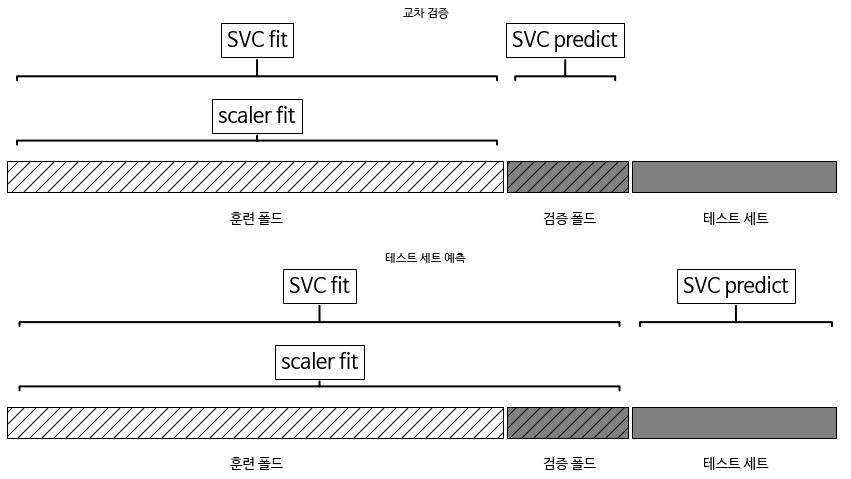

In [9]:
mglearn.plots.plot_proper_processing()

# 파이프라인 인터페이스

## 파이프라인 시각화

In [10]:
from sklearn import set_config
set_config(display='diagram')
display(pipe)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

## make_pipeline

* 이름을 클래스의 이름으로 자동 지정

In [11]:
from sklearn.pipeline import make_pipeline
pipe_short = make_pipeline(MinMaxScaler(),SVC(C=100))
pipe_short.steps

[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]

* 같은 클래스를 여러 단계에서 사용하면 이름 뒤에 숫자가 추가로 붙음

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
pipe.steps

[('standardscaler-1', StandardScaler()),
 ('pca', PCA(n_components=2)),
 ('standardscaler-2', StandardScaler())]

## 단계 속성 접근

* named_steps

In [13]:
pipe.fit(cancer.data)
components = pipe.named_steps['pca'].components_
print(components)

[[ 0.219  0.104  0.228  0.221  0.143  0.239  0.258  0.261  0.138  0.064
   0.206  0.017  0.211  0.203  0.015  0.17   0.154  0.183  0.042  0.103
   0.228  0.104  0.237  0.225  0.128  0.21   0.229  0.251  0.123  0.132]
 [-0.234 -0.06  -0.215 -0.231  0.186  0.152  0.06  -0.035  0.19   0.367
  -0.106  0.09  -0.089 -0.152  0.204  0.233  0.197  0.13   0.184  0.28
  -0.22  -0.045 -0.2   -0.219  0.172  0.144  0.098 -0.008  0.142  0.275]]


* GridSearch의 best_estimator_ -> named_steps

In [14]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
param_grid = {'logisticregression__C':[0.01, 0.1, 1, 10, 100]}
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print('최상의 모델:', grid.best_estimator_)

최상의 모델: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [15]:
grid.best_estimator_.named_steps['logisticregression'].coef_

array([[-0.436, -0.343, -0.408, -0.534, -0.15 ,  0.61 , -0.726, -0.785,
         0.039,  0.275, -1.298,  0.049, -0.673, -0.934, -0.139,  0.45 ,
        -0.13 , -0.101,  0.434,  0.716, -1.091, -1.095, -0.852, -1.064,
        -0.743,  0.073, -0.823, -0.653, -0.644, -0.42 ]])

# GridSearch에서의 활용

* 변환기, 추정기 매개변수 서치

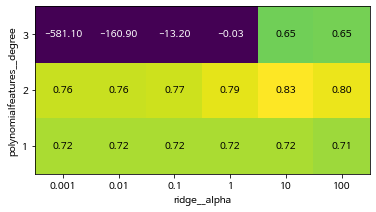

In [16]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())
param_grid = {'polynomialfeatures__degree':[1,2,3], 'ridge__alpha':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3,-1), xlabel='ridge__alpha',
                      ylabel='polynomialfeatures__degree', xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [17]:
print('최적의 매개변수:', grid.best_params_)
print(f'테스트 세트 점수: {grid.score(X_test, y_test):.2f}')

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
테스트 세트 점수: 0.77


* 추정기 자체도 서치 가능

In [18]:
pipe = Pipeline([('preprocessing', StandardScaler()),('classifier', SVC())])
from sklearn.ensemble import RandomForestClassifier

param_grid = [{'classifier':[SVC()], 'preprocessing':[StandardScaler()],
               'classifier__gamma':[0.001, 0.01, 0.1, 1, 10, 100],
               'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100]},
              {'classifier':[RandomForestClassifier(n_estimators=100)],
               'preprocessing': [None], 'classifier__max_features': [1,2,3]}]

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=4)
grid.fit(X_train, y_train)

print(f'최적의 매개변수: {grid.best_params_}')
print(f'최상의 교차 검증 점수: {grid.best_score_:.2f}')
print(f'테스트 점수: {grid.score(X_test, y_test):.2f}')

최적의 매개변수: {'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}
최상의 교차 검증 점수: 0.99
테스트 점수: 0.98
